<a href="https://colab.research.google.com/github/VeraMendes/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/VM_LS_DS_113_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

In [0]:
# makes a change

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
# dir(random)  # Reminding ourselves what we can do here

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something
random.seed(42)

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.789338167851291,5.836487686604824,7.267690340465448,7.280322437947023,7.733814701629437,7.772242279186957,7.994578759409748,8.373541587279558,9.106003254765849,9.38379653305911,9.615509927247123,9.848428900738856,10.23950442139964,10.337418715486669,10.586523414450706,10.718069679753153,10.997854148991385,11.012105109498041,11.706921559980145,12.091956561791557,12.382271645712285,12.75378790843838,12.995103670392169,13.370178930168896,15.920785346944974,16.135510245480567,16.75893133416585,16.773802946263586,16.868343577661772,17.362252869462687,17.479167161023454,17.922851319441314,18.36049180470949,18.567335759777762,19.359514766905985,19.468053978919983,19.833966879145127,20.484876517641524,20.710781715466965,20.814676916297277,...,513.5342908357718,515.4718990593212,517.1848861497105,518.3867964481467,518.4070711833585,520.1173607697788,524.578401914593,526.7532348231344,527.0568996188746,528.0256635303839,528.4459079156787,529.7098624749993,535.2695153363682,535.9412962281579,536.3859449458588,539.3527809076247,540.36553555062,542.6552719822238,543.3178572203369,548.4504252134441,549.5830779469206,561.9534019425959,564.1499127915823,564.814565730808,574.7557126020009,574.8174081072071,577.8952462993177,580.464571388533,581.5385253318037,581.7077917980032,582.5363605031145,582.9362427920347,588.8783154469735,590.65747470592,593.8187768755912,597.1381204299279,597.7116143416571,598.547187832115,599.088120104121,599.5766563635087
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,...,1,1,0,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,0,0,1,1,0,1,1,0,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0


In [13]:
pd.__version__   

'0.24.2'

In [0]:
# !pip freeze     show all versions for all libraries/packages installed

In [14]:
!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 4.9MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [9]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


In [10]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


In [11]:
pd.crosstab(user_data['purchased'], [user_data['mobile'], time_bins], normalize='columns')

mobile                  False        ...                      True 
time_on_site (5.196, 124.547]        ...         (243.304, 362.062]
purchased                            ...                           
False                0.902439        ...                   0.531915
True                 0.097561        ...                   0.468085

[2 rows x 8 columns]

In [13]:
crosstab = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')
crosstab

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(5.196, 124.547]    0.210227  0.413043  0.054054  0.351724
(124.547, 243.304]  0.244318  0.423913  0.148649  0.420690
(243.304, 362.062]  0.204545  0.163043  0.243243  0.227586
(362.062, 480.819]  0.130682  0.000000  0.270270  0.000000
(480.819, 599.577]  0.210227  0.000000  0.283784  0.000000

In [14]:
type(crosstab)

pandas.core.frame.DataFrame

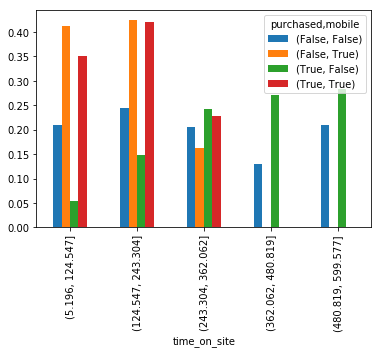

In [16]:
crosstab.plot(kind='bar')

In [19]:
crosstab_final=crosstab.iloc[2:5, : ]
crosstab_final

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(243.304, 362.062]  0.204545  0.163043  0.243243  0.227586
(362.062, 480.819]  0.130682  0.000000  0.270270  0.000000
(480.819, 599.577]  0.210227  0.000000  0.283784  0.000000

In [20]:
crosstab_final2=crosstab.iloc[:, 2:4 ]
crosstab_final2

purchased               True          
mobile                 False     True 
time_on_site                          
(5.196, 124.547]    0.054054  0.351724
(124.547, 243.304]  0.148649  0.420690
(243.304, 362.062]  0.243243  0.227586
(362.062, 480.819]  0.270270  0.000000
(480.819, 599.577]  0.283784  0.000000

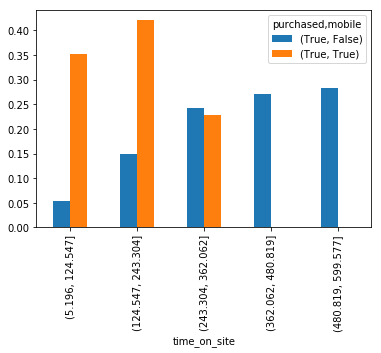

In [21]:
crosstab_final2.plot(kind='bar')

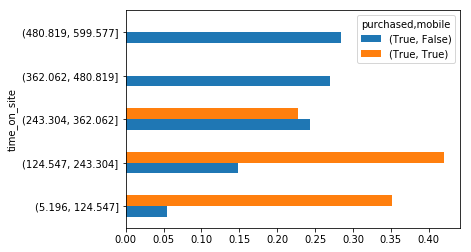

In [29]:
crosstab_final2.plot(kind='barh');

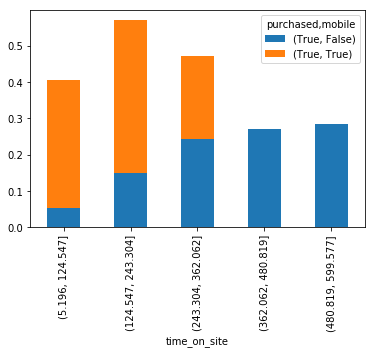

In [28]:
crosstab_final2.plot(kind='bar', stacked=True);

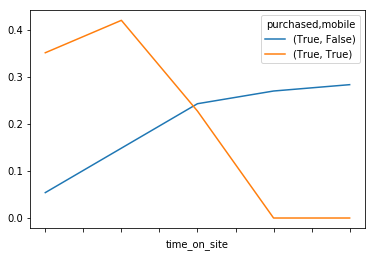

In [27]:
crosstab_final2.plot();

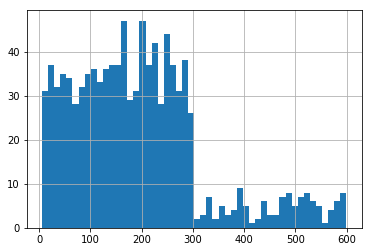

In [26]:
user_data['time_on_site'].hist(bins=50);

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?